# Are Ryan-Joiner and PPCC tests the same?

## Imports

In [1]:
from normtest import ryan_joiner, filliben
from normtest.utils.critical_values import LOONEY_GULLEDGE_CRITICAL
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
#import warnings <-------- important on R
#warnings.filterwarnings("ignore")

## General variables

In [2]:
n_min = 3
n_max = 10
alpha = 0.05
n_sample_name = "Tamanho amostral"
lg_name = "Looney-Gulledge"
rj_name = "Ryan-Joiner"
diff_name = "Diferença"
alpha_name = "Alfa"
critical_name = "Valores críticos"
percentage_name = "Porcentagem (%)"
desv_pad_name = "Desvio padrão*"
diff_quadract = "Diferença quadrática média"
positive_name, negative_name, zero_name = "Positiva", "Negativa", "Nula"
alphas = [0.01, 0.05, 0.10]

## Filliben example plot

C:\Users\ander\AppData\Local\Temp\ipykernel_27112\2175911843.py:3: UserWarning: This function is experimental and its behavior may not be ideal.


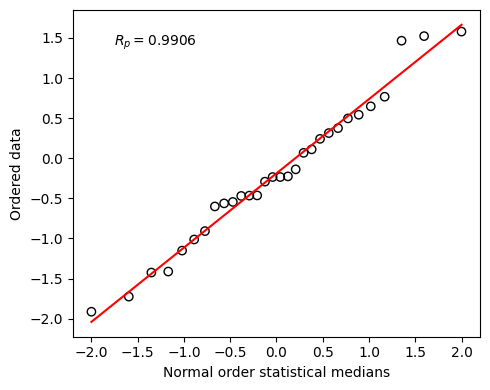

In [3]:
data = stats.norm.rvs(loc=0, scale=1, size=30, random_state=42)
fig, ax = plt.subplots(figsize=(5, 4))
ax = filliben.correlation_plot(ax, data)
# plt.savefig("correlation_plot.png")
fig.tight_layout()
plt.show()

## Making the data

In [4]:
all_values = []
rj_criticals = []
lg_criticals = []
diffs = []

for alpha_value in alphas:
    rj_critico = []
    for i in LOONEY_GULLEDGE_CRITICAL["n"][3:]:
        rj_critico.append(round(ryan_joiner._critical_value(i, alpha=alpha_value), 3))
    rj_critico = np.array(rj_critico)
    lg_critico = np.array(LOONEY_GULLEDGE_CRITICAL[alpha_value][3:])

    dff = rj_critico - lg_critico
    all_values.append(
        pd.DataFrame(
            {
                n_sample_name: LOONEY_GULLEDGE_CRITICAL["n"][3:],
                rj_name: lg_critico,
                lg_name: rj_critico,
                diff_name: dff,
                alpha_name: [alpha_value] * dff.size,
            }
        )
    )
    diffs.append(
        pd.DataFrame(
            {
                alpha_name: [alpha_value],
                diff_name: [np.square(rj_critico - lg_critico).sum() / rj_critico.size],
            }
        )
    )


df = pd.concat(all_values)





## Table with critical values between n_min and n__max

In [5]:
### Tabela com valores críticos entre n_min e n__max

df_critical_table = df[df[alpha_name] == alpha].copy()
df_critical_table.drop(alpha_name, inplace=True, axis=1)
df_critical_table = df_critical_table.loc[
    df_critical_table[n_sample_name].isin(np.arange(n_min, n_max + 1))
]
df_critical_table

,Tamanho amostral,Ryan-Joiner,Looney-Gulledge,Diferença
0,3,0.879,0.878,-0.001
1,4,0.868,0.873,0.005
2,5,0.880,0.880,0.000
3,6,0.888,0.889,0.001
4,7,0.898,0.898,0.000
5,8,0.906,0.905,-0.001
6,9,0.912,0.912,0.000
7,10,0.918,0.918,0.000


## Graph comparing critical values to available confidence levels

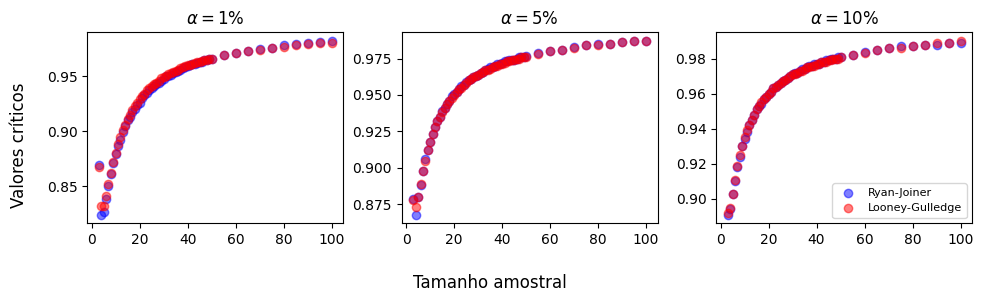

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for alpha_value, ax in zip(alphas, axes):
    df_aux = df[df[alpha_name] == alpha_value].copy()
    ax.scatter(
        df_aux[n_sample_name], df_aux[rj_name], label=rj_name, color="blue", alpha=0.5
    )
    ax.scatter(
        df_aux[n_sample_name], df_aux[lg_name], label=lg_name, color="red", alpha=0.5
    )
    ax.set_title("$\\alpha=" + f"{round(alpha_value*100)}" + "\\%$")


ax.legend(loc=4, fontsize=8)

fig.supxlabel(n_sample_name)
fig.supylabel(critical_name)
fig.tight_layout()
plt.show()

### Graph with the differences between critical values

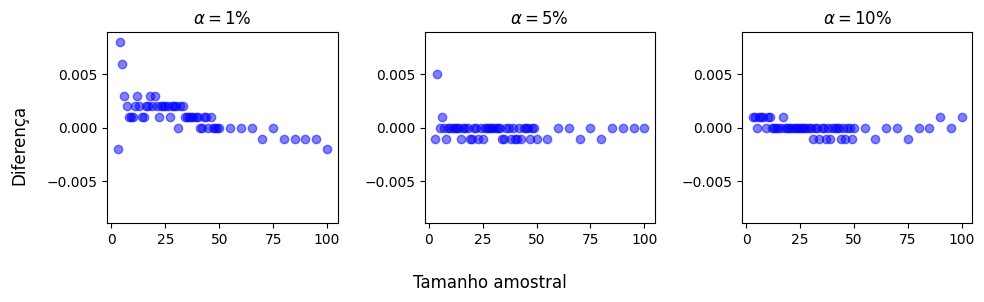

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
y_lims = 0
for alpha_value, ax in zip(alphas, axes):
    df_aux = df[df[alpha_name] == alpha_value].copy()
    ax.scatter(df_aux[n_sample_name], df_aux[diff_name], color="blue", alpha=0.5)
    ax.set_title("$\\alpha=" + f"{round(alpha_value*100)}" + "\\%$")
    ylims = ax.get_ylim()
    y_max = np.max(np.abs(ylims))

    if y_max > y_lims:
        y_lims = y_max

for ax in axes:
    ax.set_ylim(-1.05 * y_lims, y_lims * 1.05)

# ax.legend(loc=4, fontsize=8)

fig.supxlabel(n_sample_name)
fig.supylabel(diff_name)
fig.tight_layout()
plt.show()


## Table of quadratic differences quadratic differences

In [8]:
df_quadract = []
for alpha_value in alphas:
    df_aux = df[[diff_name, alpha_name]].copy()
    df_aux = df_aux[df_aux[alpha_name] == alpha_value]

    df_quadract.append(
        pd.DataFrame(
            {
                alpha_name: [alpha_value],
                diff_quadract: [np.square(df_aux[diff_name]).sum() / (df_aux.shape[0] - 1)],
            }
        )
    )

df_quadract = pd.concat(df_quadract, ignore_index=True)
df_quadract[desv_pad_name] = np.sqrt(df_quadract[diff_quadract])
df_quadract

,Alfa,Diferença quadrática média,Desvio padrão*
0,0.01,4.035088e-06,0.002009
1,0.05,7.719298e-07,0.000879
2,0.10,3.333333e-07,0.000577


### Bar chart with counting differences

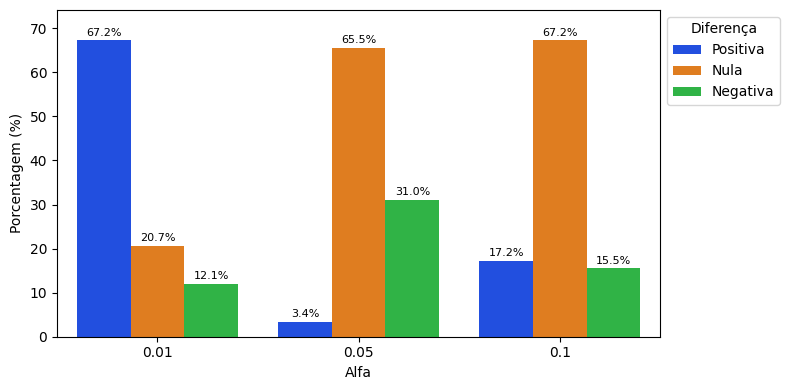

In [9]:
def values(x):
    if x < 0:
        return negative_name
    elif x == 0:
        return zero_name
    else:
        return positive_name
        
dffs = []
for alpha_values in alphas:
    df_aux = df[df[alpha_name] == alpha_values].copy()
    df_aux[diff_name] = df_aux[diff_name].apply(values)

    # print(df.head())

    df_aux = (
        pd.Series(df_aux[diff_name]).value_counts()
        .rename_axis(diff_name)
        .reset_index(name="counts")
    )
    df_aux[percentage_name] = df_aux["counts"] * 100 / df_aux["counts"].sum()
    df_aux[alpha_name] = [alpha_values] * df_aux.shape[0]
    dffs.append(df_aux)

df_positive_negative_perncetages = pd.concat(dffs)

fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.barplot(
    data=df_positive_negative_perncetages,
    x=alpha_name,
    y=percentage_name,
    hue=diff_name,
    ax=ax,
    legend=True,
    palette="bright",
)
ax.set_xlabel(None)
ax.set_ylabel(percentage_name)
for lab in ax.containers:
    ax.bar_label(
        lab,
        labels=[f"{x:,.1f}%" for x in lab.datavalues],
        padding=2,
        rotation=0,
        fontsize=8,
    )
ax.set_xlabel(alpha_name)
ylims = ax.get_ylim()
ax.set_ylim(ylims[0], ylims[1] * 1.05)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()
# plt.savefig("dist_plot.png")
plt.show()